# Imports

In [91]:
# Import necessary libraries
import imageio
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing, gaussian_filter, median_filter, morphological_gradient, binary_dilation, label
from scipy import ndimage
import cv2

# Path to the images
image_folder = "../Data/Week2/qsd2_w2/"  # Update this path as necessary
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()
mask_files.sort()

In [92]:
def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    # Normalize RGB values to [0, 1]
    image = image / 255.0

    # Apply the standard RGB-to-grayscale formula:
    # Luminance = 0.2989 * R + 0.5870 * G + 0.1140 * B
    gray_image = 0.2989 * image[..., 0] + 0.5870 * image[..., 1] + 0.1140 * image[..., 2]

    # Ensure values are in [0, 255] range
    gray_image = np.clip(gray_image * 255, 0, 255).astype(np.uint8)
    
    return gray_image

# Func Principal

In [ ]:
def preprocess_image(image, filter_type=None):
    """Apply optional noise reduction filter to the image."""
    if filter_type == 'gaussian':
        return gaussian_filter(image, sigma=1)
    elif filter_type == 'median':
        return median_filter(image, size=3)
    return image


def convert_to_grayscale(image):
    """Convert RGB image to grayscale using LAB color space (L channel)."""
    im_lab = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    L, a, b = cv2.split(im_lab)
    return L.astype(float)


def compute_edge_mask(im_gray, gradient_threshold=0.15):
    """Compute morphological gradient and create binary edge mask."""
    # Compute morphological gradient to detect edge changes
    grad = morphological_gradient(im_gray, structure=np.ones((5, 5)))
    
    # Threshold to highlight edges
    threshold = np.max(grad) * gradient_threshold
    grad_bin = grad > threshold
    
    # Apply opening to remove small objects
    mask = binary_opening(grad_bin, structure=np.ones((3, 3)))
    
    return mask, grad


def create_border_suppressed_mask(mask_bool, pixel_border, h, w):
    """Create a mask with border pixels suppressed for extreme point computation."""
    if not pixel_border or int(pixel_border) <= 0:
        return mask_bool
    
    mask_for_extremes = mask_bool.copy()
    pb = int(pixel_border)
    
    # Avoid border larger than dimensions
    pb_h = min(pb, h // 2)
    pb_w = min(pb, w // 2)
    
    # Suppress border pixels
    if pb_w > 0:
        mask_for_extremes[:, :pb_w] = False
        mask_for_extremes[:, w - pb_w:] = False
    if pb_h > 0:
        mask_for_extremes[:pb_h, :] = False
        mask_for_extremes[h - pb_h:, :] = False
    
    return mask_for_extremes


def compute_extreme_points(mask_for_extremes, h, w):
    """Compute leftmost, rightmost, topmost, and bottommost white pixels."""
    # Row-wise extremes (leftmost and rightmost white pixel per row)
    rows_any = mask_for_extremes.any(axis=1)
    left_all = mask_for_extremes.argmax(axis=1)
    right_all = w - 1 - np.argmax(mask_for_extremes[:, ::-1], axis=1)
    left = np.where(rows_any, left_all, -1)
    right = np.where(rows_any, right_all, -1)
    
    # Column-wise extremes (topmost and bottommost white pixel per column)
    cols_any = mask_for_extremes.any(axis=0)
    top_all = mask_for_extremes.argmax(axis=0)
    bottom_all = h - 1 - np.argmax(mask_for_extremes[::-1, :], axis=0)
    top = np.where(cols_any, top_all, -1)
    bottom = np.where(cols_any, bottom_all, -1)
    
    return left, right, top, bottom, rows_any, cols_any


def filter_extremes_by_median(extremes, threshold):
    """Filter extreme points by median deviation threshold."""
    filtered = extremes.copy()
    valid = filtered >= 0
    
    if valid.any():
        median_val = int(np.median(filtered[valid]))
        filtered[valid] = np.where(
            np.abs(filtered[valid] - median_val) <= threshold,
            filtered[valid],
            -1
        )
    
    return filtered


def create_border_mask(left, right, top, bottom, rows_any, cols_any, shape):
    """Create a border mask by marking filtered extreme points."""
    border_mask = np.zeros(shape, dtype=bool)
    
    # Mark left and right extremes for each row
    row_inds = np.where(rows_any)[0]
    for r in row_inds:
        if left[r] >= 0:
            border_mask[r, left[r]] = True
        if right[r] >= 0:
            border_mask[r, right[r]] = True
    
    # Mark top and bottom extremes for each column
    col_inds = np.where(cols_any)[0]
    for c in col_inds:
        if top[c] >= 0:
            border_mask[top[c], c] = True
        if bottom[c] >= 0:
            border_mask[bottom[c], c] = True
    
    return border_mask


def fit_x_of_y(y_indices, x_values):
    """Fit line x = a*y + b for vertical-like sides."""
    if len(y_indices) >= 2:
        a, b = np.polyfit(y_indices, x_values, 1)
    elif len(y_indices) == 1:
        a, b = 0.0, float(x_values[0])
    else:
        a, b = None, None
    return a, b


def fit_y_of_x(x_indices, y_values):
    """Fit line y = c*x + d for horizontal-like sides."""
    if len(x_indices) >= 2:
        c, d = np.polyfit(x_indices, y_values, 1)
    elif len(x_indices) == 1:
        c, d = 0.0, float(y_values[0])
    else:
        c, d = None, None
    return c, d


def intersect_lines(a, b, c, d):
    """Find intersection between lines x = a*y + b and y = c*x + d."""
    if a is None or c is None:
        return None
    
    denom = 1.0 - a * c
    if abs(denom) < 1e-6:
        return None
    
    x = (a * d + b) / denom
    y = c * x + d
    return (x, y)


def compute_polygon_corners(left, right, top, bottom, h, w):
    """Compute the four corners of the document polygon by fitting lines and finding intersections."""
    # Collect valid points for each side
    rows_left = np.where(left >= 0)[0]
    xs_left = left[rows_left] if rows_left.size > 0 else np.array([])
    
    rows_right = np.where(right >= 0)[0]
    xs_right = right[rows_right] if rows_right.size > 0 else np.array([])
    
    cols_top = np.where(top >= 0)[0]
    ys_top = top[cols_top] if cols_top.size > 0 else np.array([])
    
    cols_bottom = np.where(bottom >= 0)[0]
    ys_bottom = bottom[cols_bottom] if cols_bottom.size > 0 else np.array([])
    
    # Fit lines for each side
    a_left, b_left = fit_x_of_y(rows_left, xs_left)
    a_right, b_right = fit_x_of_y(rows_right, xs_right)
    c_top, d_top = fit_y_of_x(cols_top, ys_top)
    c_bottom, d_bottom = fit_y_of_x(cols_bottom, ys_bottom)
    
    # Compute four corner intersections
    corners = [
        intersect_lines(a_left, b_left, c_top, d_top),      # left-top
        intersect_lines(a_right, b_right, c_top, d_top),    # right-top
        intersect_lines(a_right, b_right, c_bottom, d_bottom),  # right-bottom
        intersect_lines(a_left, b_left, c_bottom, d_bottom)     # left-bottom
    ]
    
    # Apply fallback for None intersections
    final_corners = []
    for i, corner in enumerate(corners):
        if corner is None:
            # Use median of available points as fallback
            if i == 0:  # left-top
                x = np.median(xs_left) if xs_left.size > 0 else 0
                y = np.median(ys_top) if ys_top.size > 0 else 0
            elif i == 1:  # right-top
                x = np.median(xs_right) if xs_right.size > 0 else (w - 1)
                y = np.median(ys_top) if ys_top.size > 0 else 0
            elif i == 2:  # right-bottom
                x = np.median(xs_right) if xs_right.size > 0 else (w - 1)
                y = np.median(ys_bottom) if ys_bottom.size > 0 else (h - 1)
            else:  # left-bottom
                x = np.median(xs_left) if xs_left.size > 0 else 0
                y = np.median(ys_bottom) if ys_bottom.size > 0 else (h - 1)
            corner = (float(x), float(y))
        
        # Clip to image boundaries and convert to integers
        x_cl = int(np.clip(round(corner[0]), 0, w - 1))
        y_cl = int(np.clip(round(corner[1]), 0, h - 1))
        final_corners.append((x_cl, y_cl))
    
    return final_corners


def create_polygon_mask(corners, shape, fallback_mask):
    """Create a filled polygon mask from corner points."""
    h, w = shape
    polygon = np.array(corners, dtype=np.int32)
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    
    try:
        cv2.fillPoly(poly_mask, [polygon], 1)
    except Exception:
        # Fallback to border mask if polygon is degenerate
        poly_mask = fallback_mask.astype(np.uint8)
    
    return poly_mask


def normalize_gradient(grad):
    """Normalize gradient values to 0-255 range for visualization."""
    grad_float = grad.astype(np.float32)
    grad_min = grad_float.min()
    grad_max = grad_float.max()
    grad_norm = 255 * (grad_float - grad_min) / ((grad_max - grad_min) + 1e-8)
    return grad_norm.astype(np.uint8)


def remove_background_morphological_gradient(image, filter=None, save_debug=True, 
                                             thr=20, pixel_border=15):
    """
    Remove background from an image using morphological gradient detection and polygon fitting.
    
    Parameters:
    -----------
    image : ndarray
        Input RGB image
    filter : str, optional
        Filter type for noise reduction ('gaussian', 'median', or None)
    save_debug : bool
        Whether to display debug visualization of the edge mask
    thr : int
        Threshold for median filtering of extreme points
    pixel_border : int
        Number of border pixels to ignore when computing extreme points
    
    Returns:
    --------
    tuple
        (original_image, mask, output_image, normalized_gradient)
    """
    # Preprocess
    im = preprocess_image(image, filter)
    
    # Convert to grayscale using LAB color space
    im_gray = convert_to_grayscale(im)
    
    # Compute edge mask and gradient
    mask, grad = compute_edge_mask(im_gray)
    
    # Display debug mask if requested
    if save_debug:
        plt.imshow(mask, cmap="gray")
        plt.show()
    
    # Setup for border pixel processing
    mask_bool = mask.astype(bool)
    h, w = mask_bool.shape
    
    # Create mask with borders suppressed for extreme point computation
    mask_for_extremes = create_border_suppressed_mask(mask_bool, pixel_border, h, w)
    
    # Compute extreme points (leftmost, rightmost, topmost, bottommost)
    left, right, top, bottom, rows_any, cols_any = compute_extreme_points(
        mask_for_extremes, h, w
    )
    
    # Filter extremes by median deviation threshold
    left_filtered = filter_extremes_by_median(left, thr)
    right_filtered = filter_extremes_by_median(right, thr)
    top_filtered = filter_extremes_by_median(top, thr)
    bottom_filtered = filter_extremes_by_median(bottom, thr)
    
    # Create border mask from filtered extremes
    border_mask = create_border_mask(
        left_filtered, right_filtered, top_filtered, bottom_filtered,
        rows_any, cols_any, mask_bool.shape
    )
    
    # Fit lines and compute polygon corners
    final_corners = compute_polygon_corners(
        left_filtered, right_filtered, top_filtered, bottom_filtered, h, w
    )
    
    # Create polygon mask
    poly_mask = create_polygon_mask(final_corners, (h, w), border_mask)
    
    # Apply mask to image
    output_image = im * poly_mask[:, :, np.newaxis]
    
    # Normalize gradient for visualization
    grad_norm = normalize_gradient(grad)
    
    return im, poly_mask, output_image, grad_norm

C:\Users\Adrià\AppData\Local\Temp\ipykernel_23264\3534045239.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)
C:\Users\Adrià\AppData\Local\Temp\ipykernel_23264\3534045239.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_raw = imageio.imread(gt_path)


00000.jpg -> Precision: 0.8426, Recall: 0.9997, F1: 0.9144


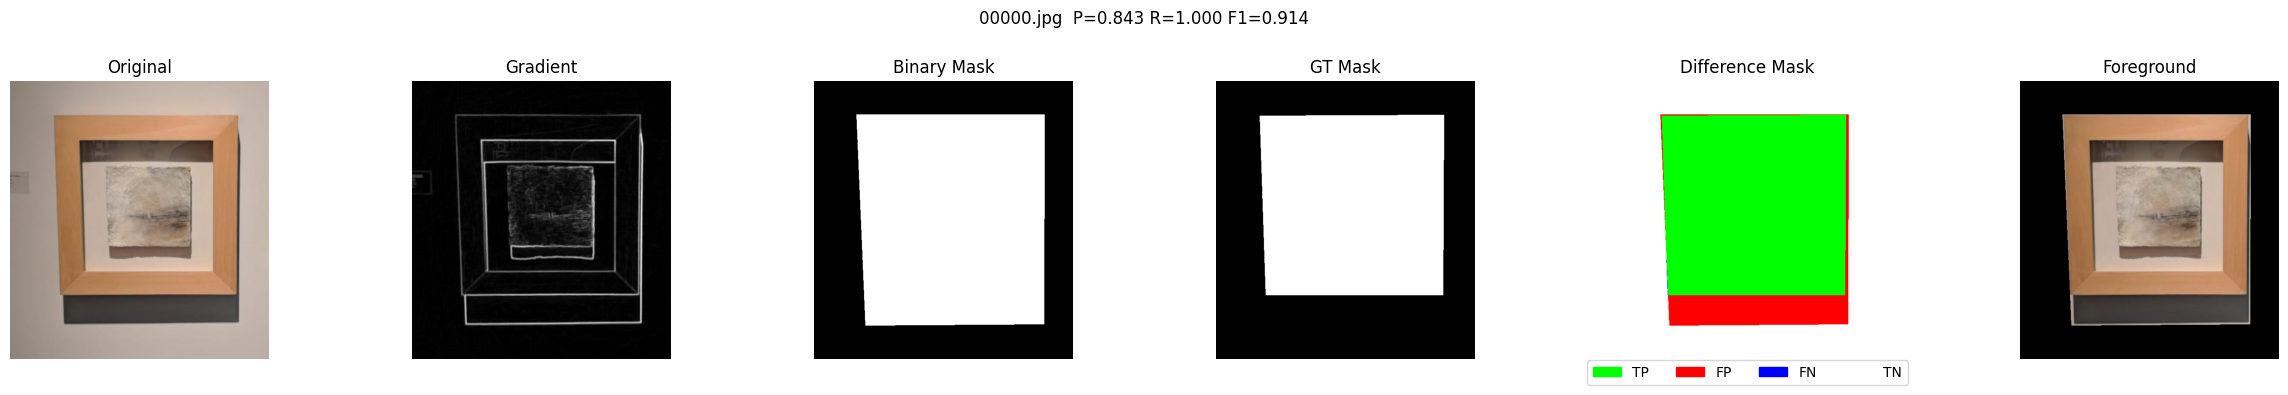

00001.jpg -> Precision: 0.9388, Recall: 1.0000, F1: 0.9684


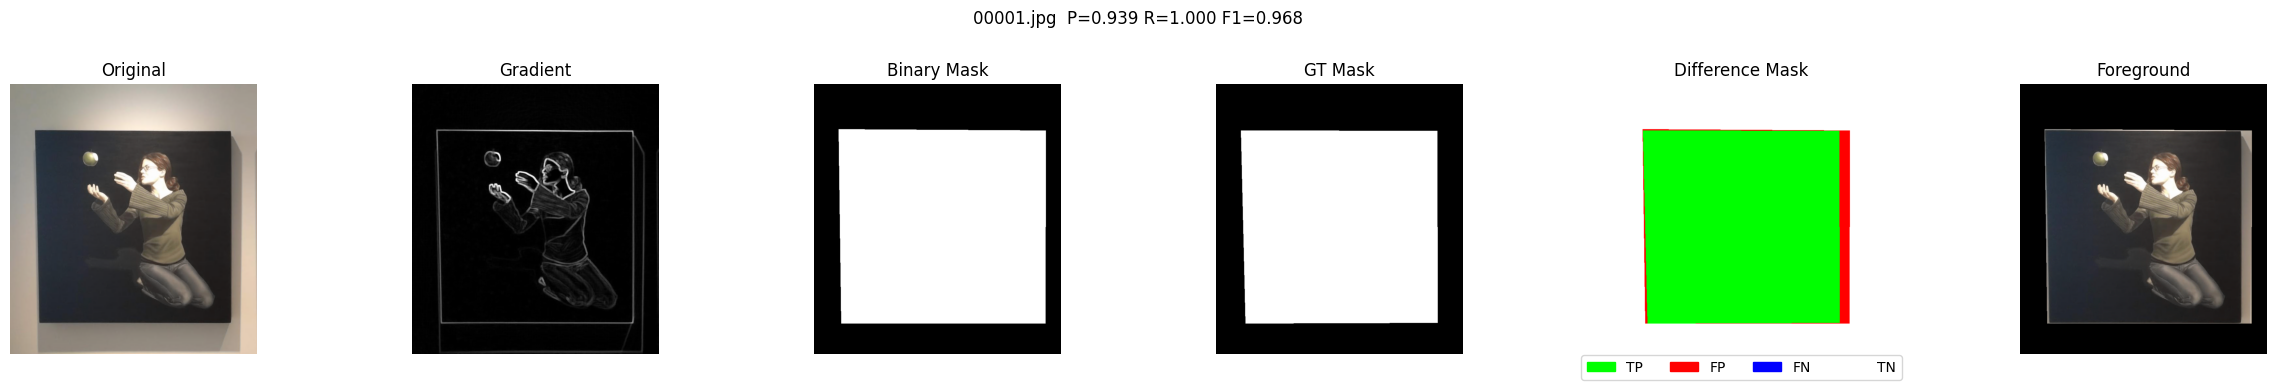

00002.jpg -> Precision: 0.9112, Recall: 1.0000, F1: 0.9535


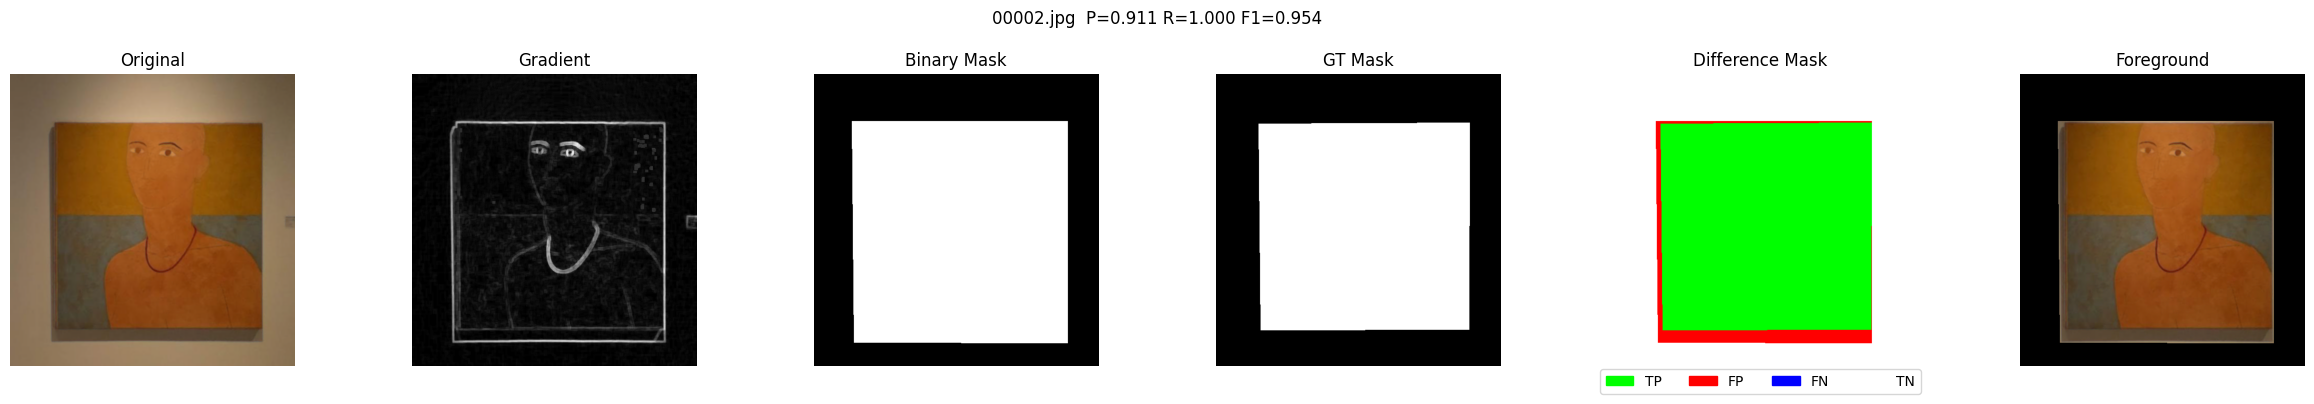

00003.jpg -> Precision: 0.8481, Recall: 1.0000, F1: 0.9178


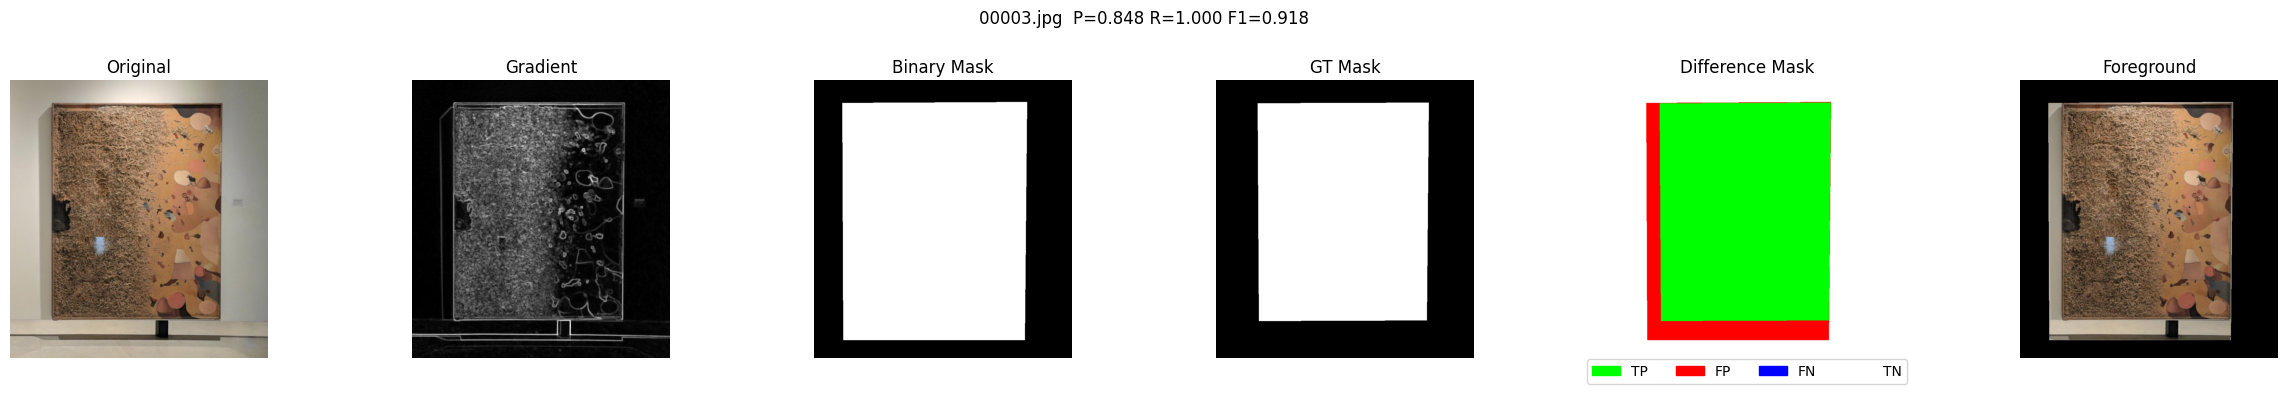

00004.jpg -> Precision: 0.8524, Recall: 1.0000, F1: 0.9203


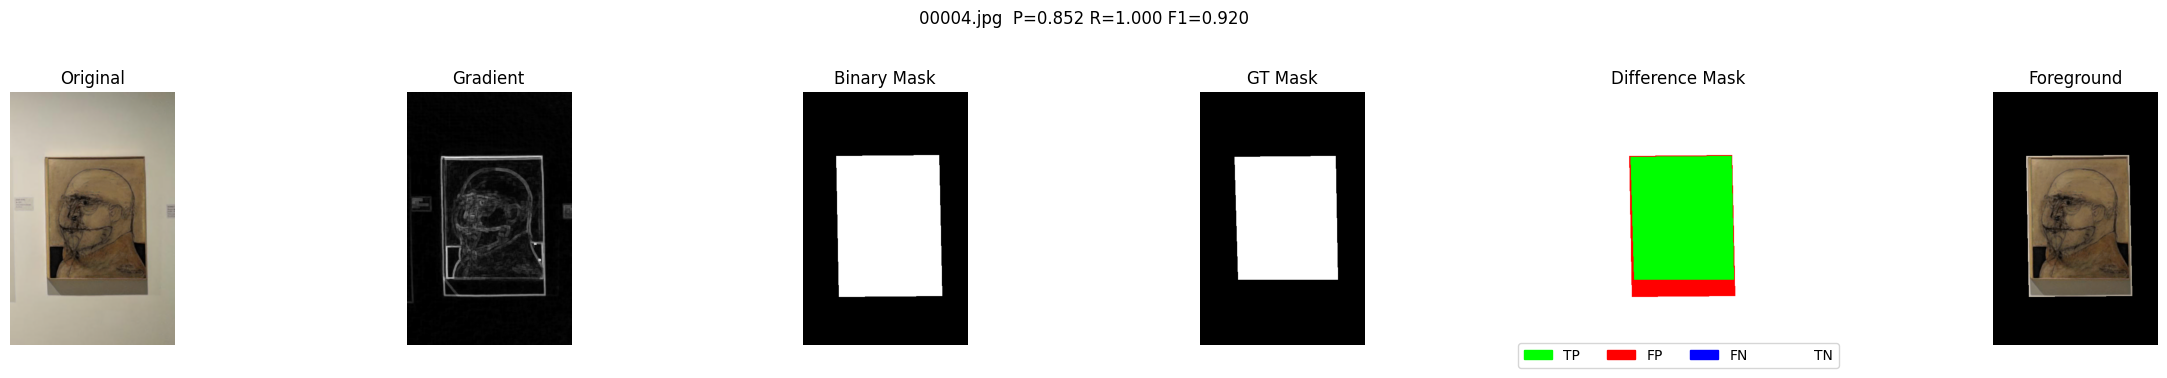

00005.jpg -> Precision: 0.9937, Recall: 0.9964, F1: 0.9950


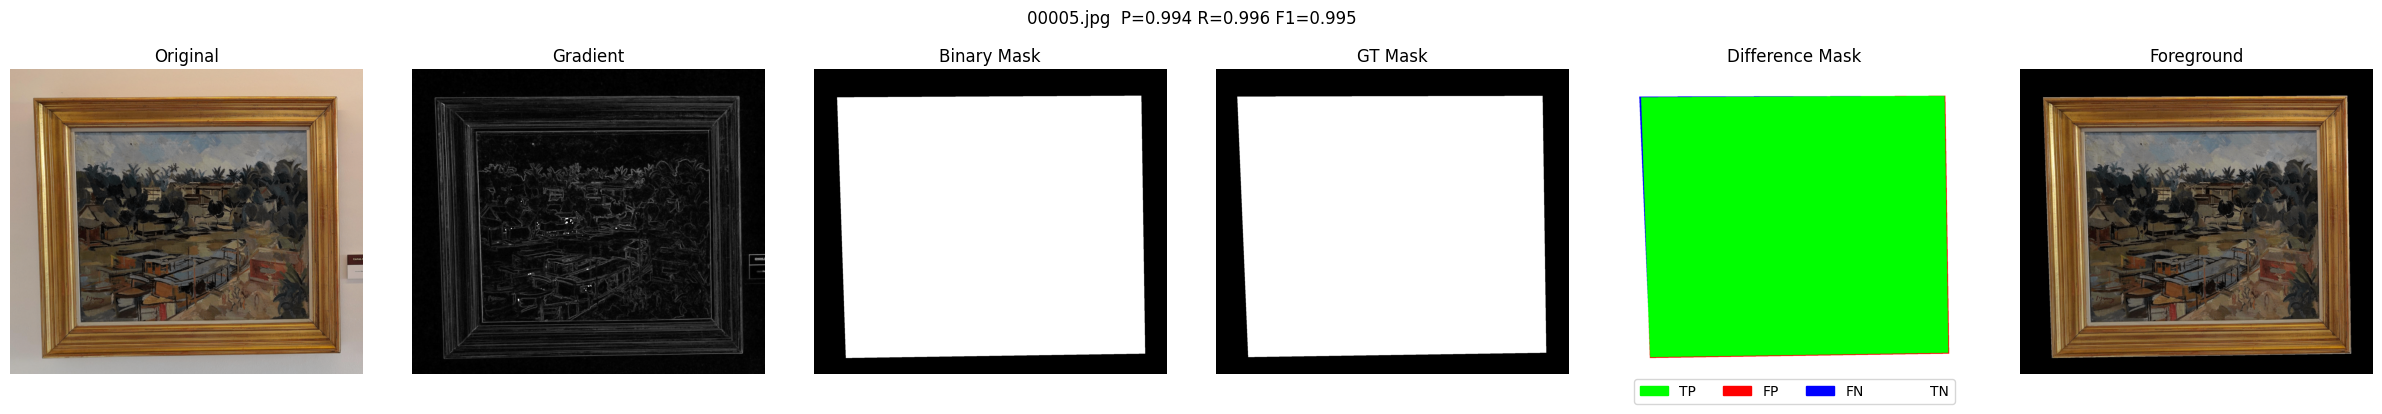

00006.jpg -> Precision: 0.9935, Recall: 0.9995, F1: 0.9965


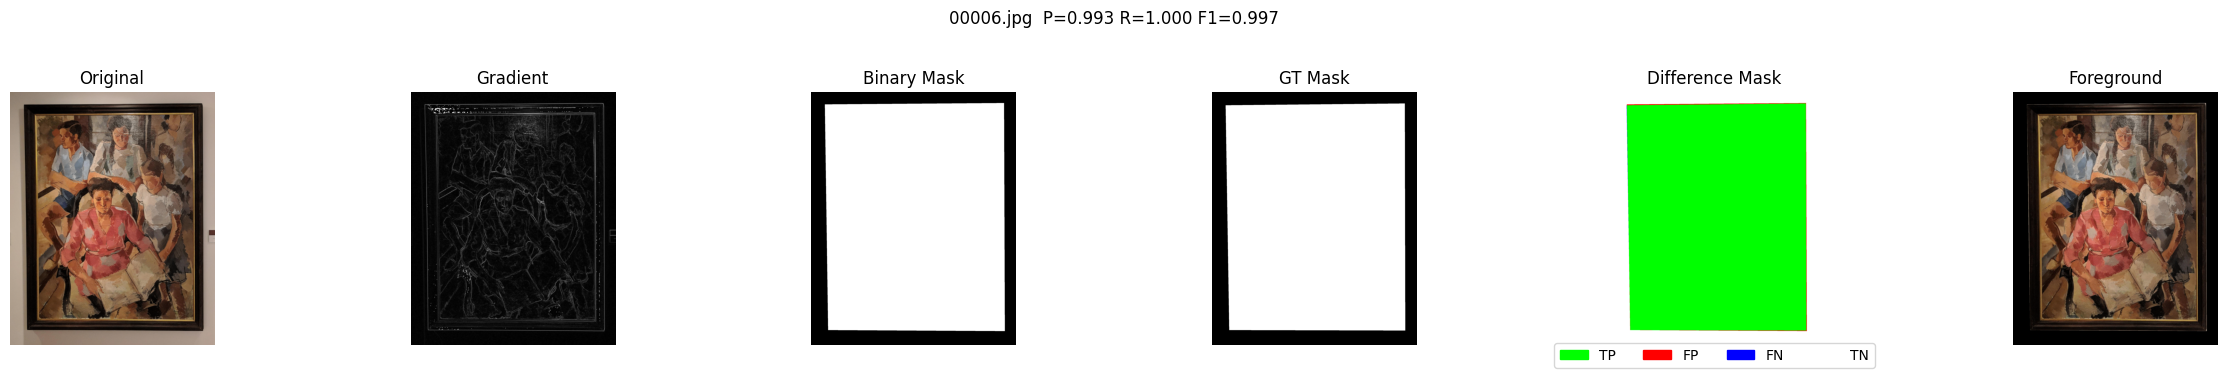

00007.jpg -> Precision: 0.8764, Recall: 1.0000, F1: 0.9342


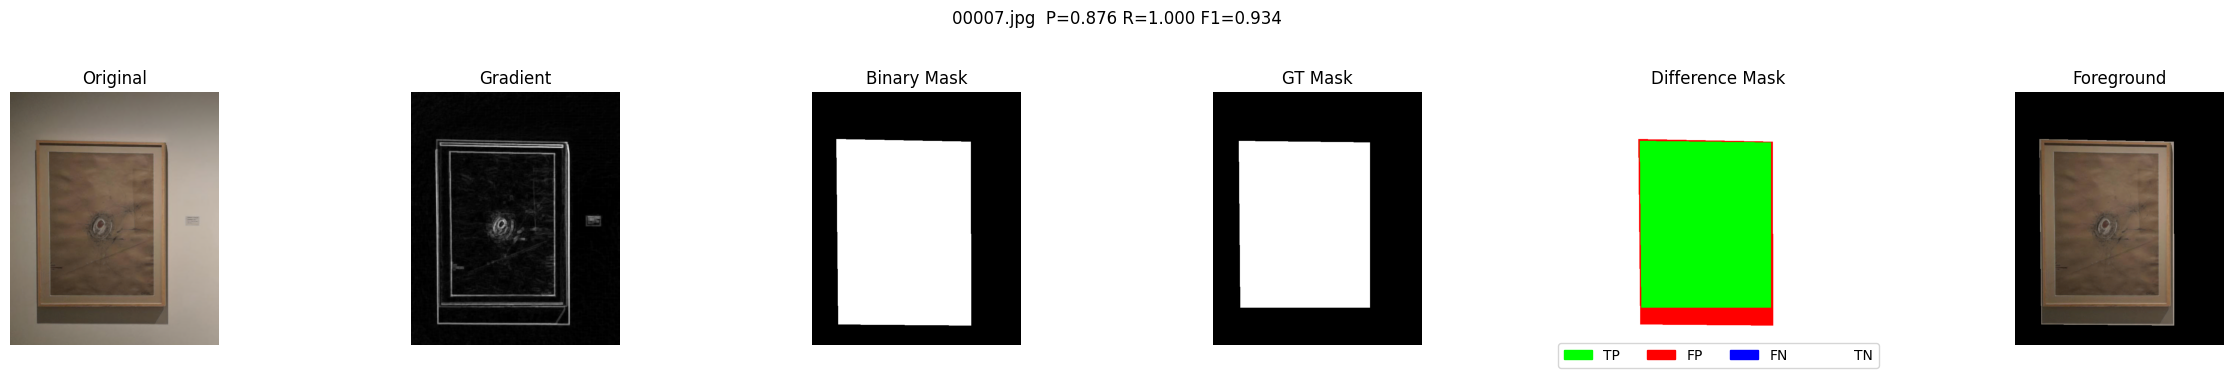

00008.jpg -> Precision: 0.9461, Recall: 1.0000, F1: 0.9723


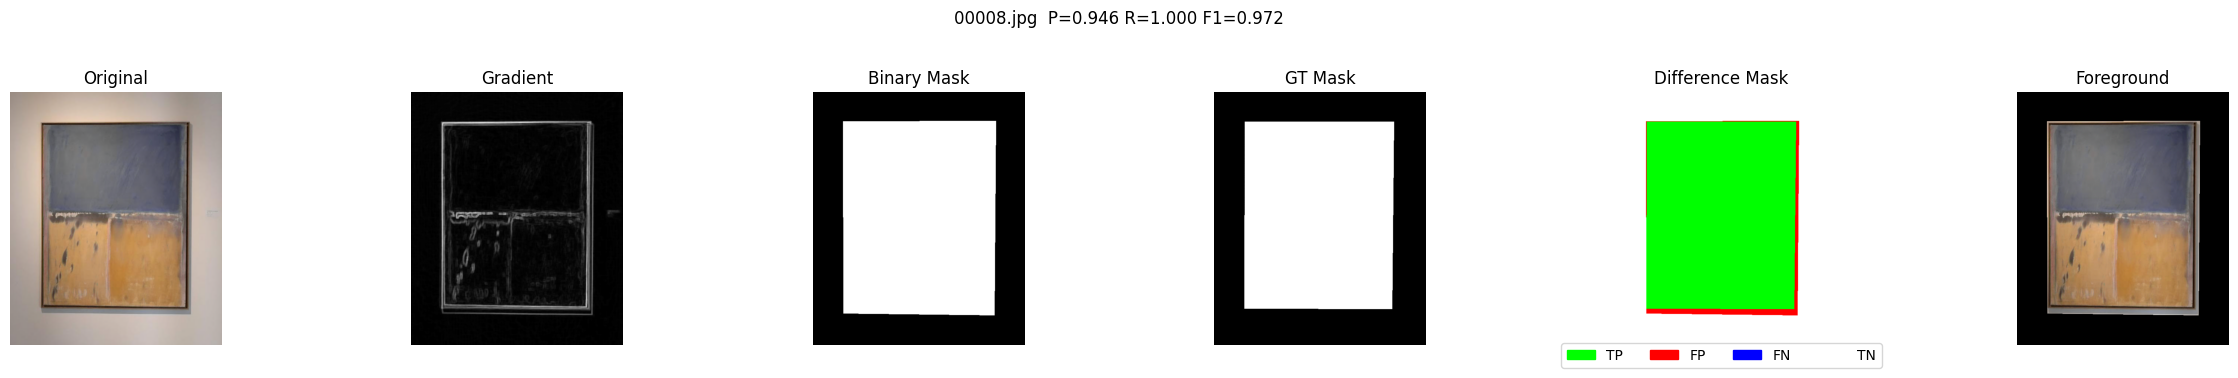

00009.jpg -> Precision: 0.8465, Recall: 0.9994, F1: 0.9166


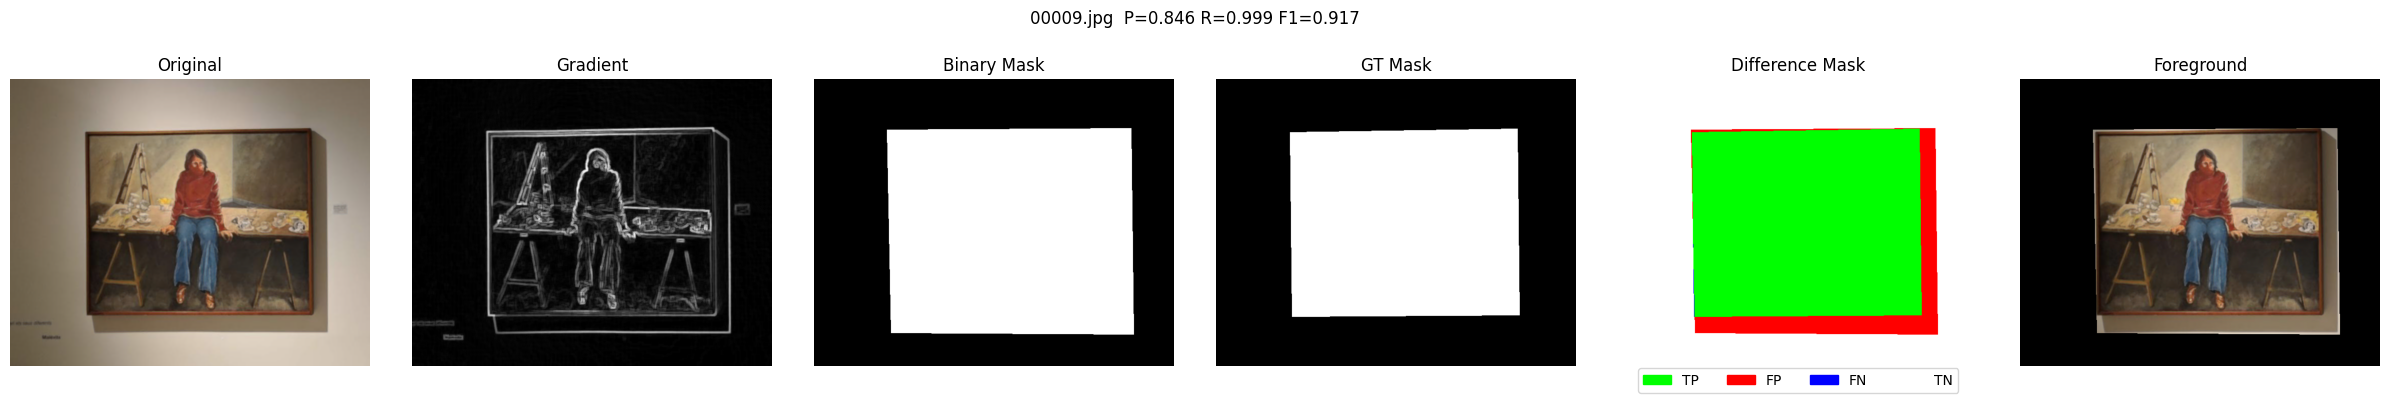

00010.jpg -> Precision: 0.9817, Recall: 0.9975, F1: 0.9895


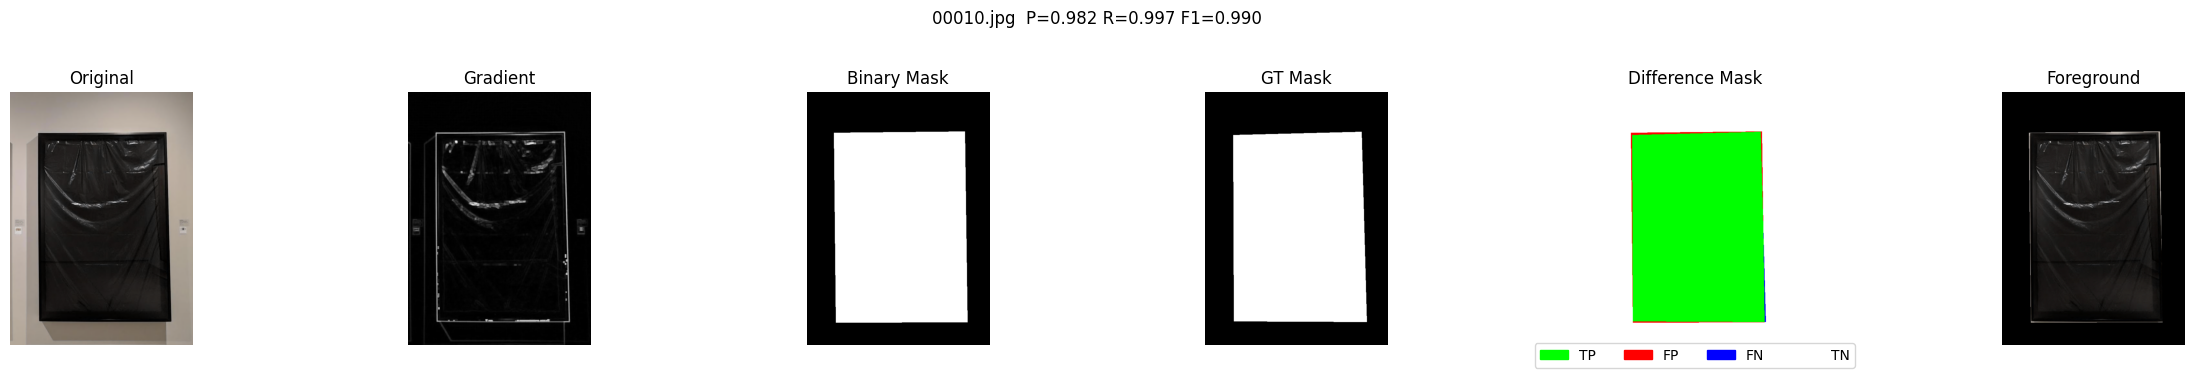

00011.jpg -> Precision: 0.9944, Recall: 0.9953, F1: 0.9948


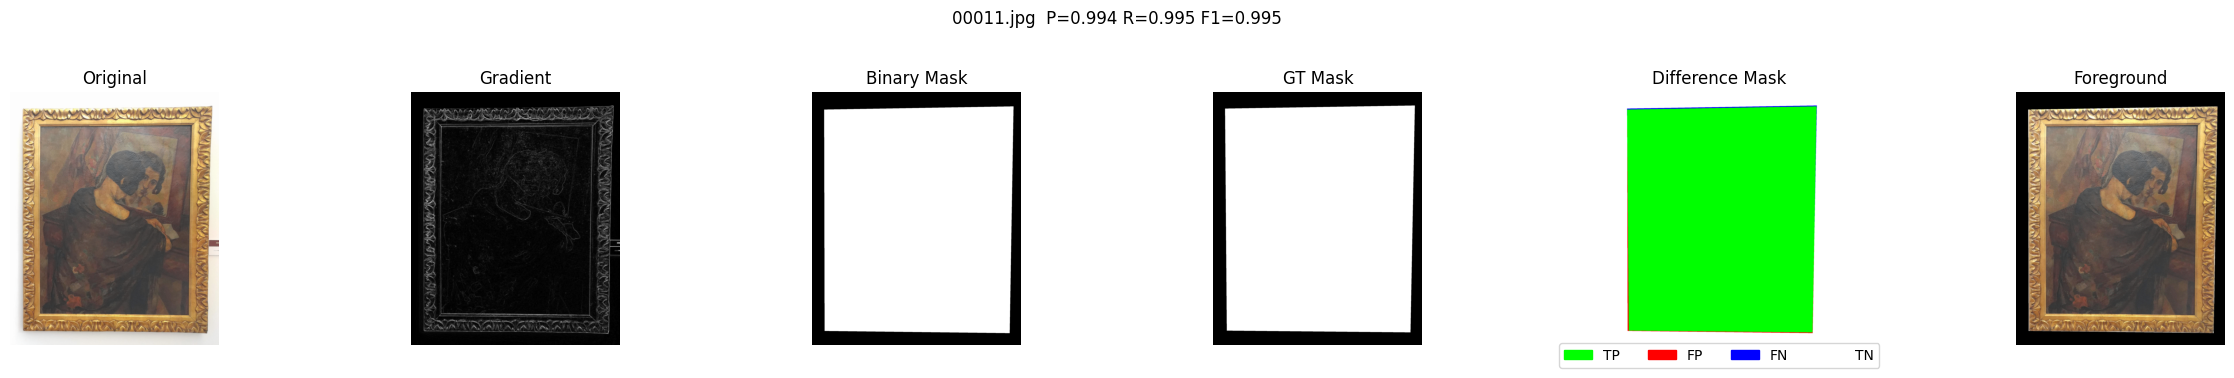

00012.jpg -> Precision: 0.9931, Recall: 0.9984, F1: 0.9957


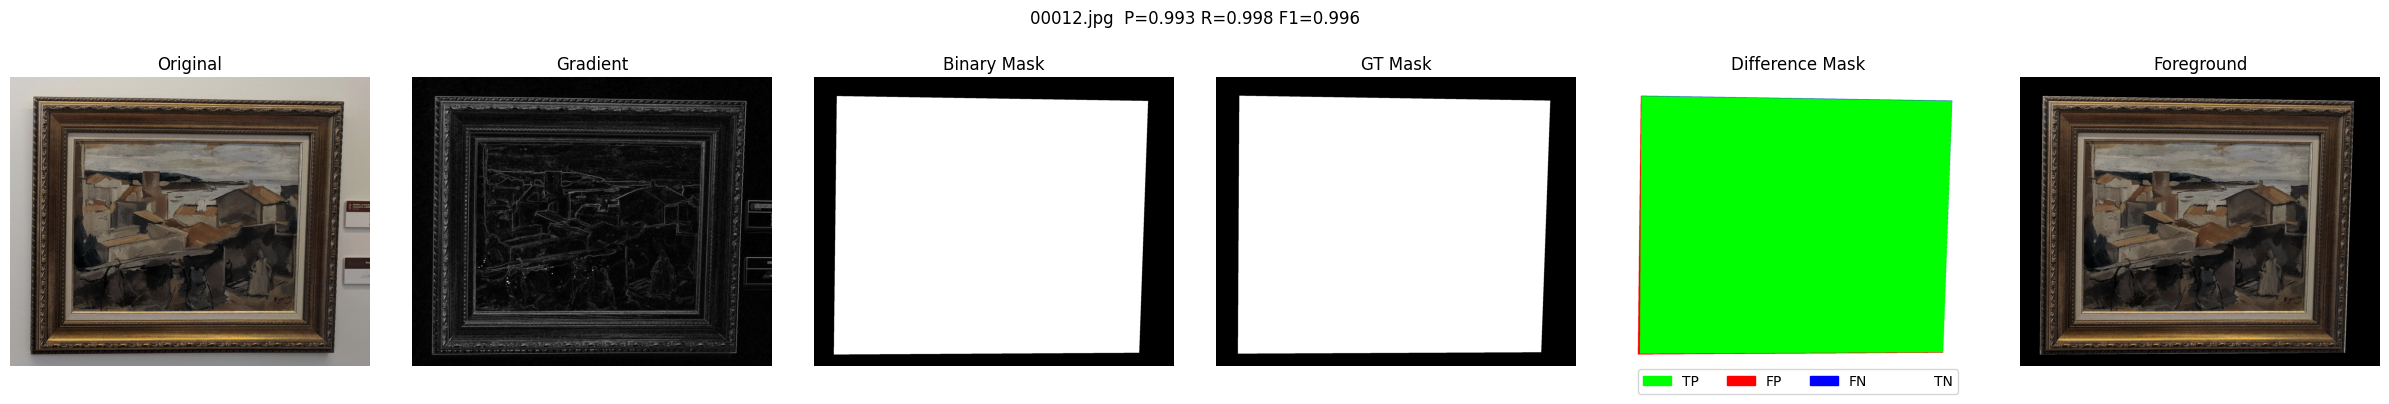

00013.jpg -> Precision: 0.9678, Recall: 0.9666, F1: 0.9672


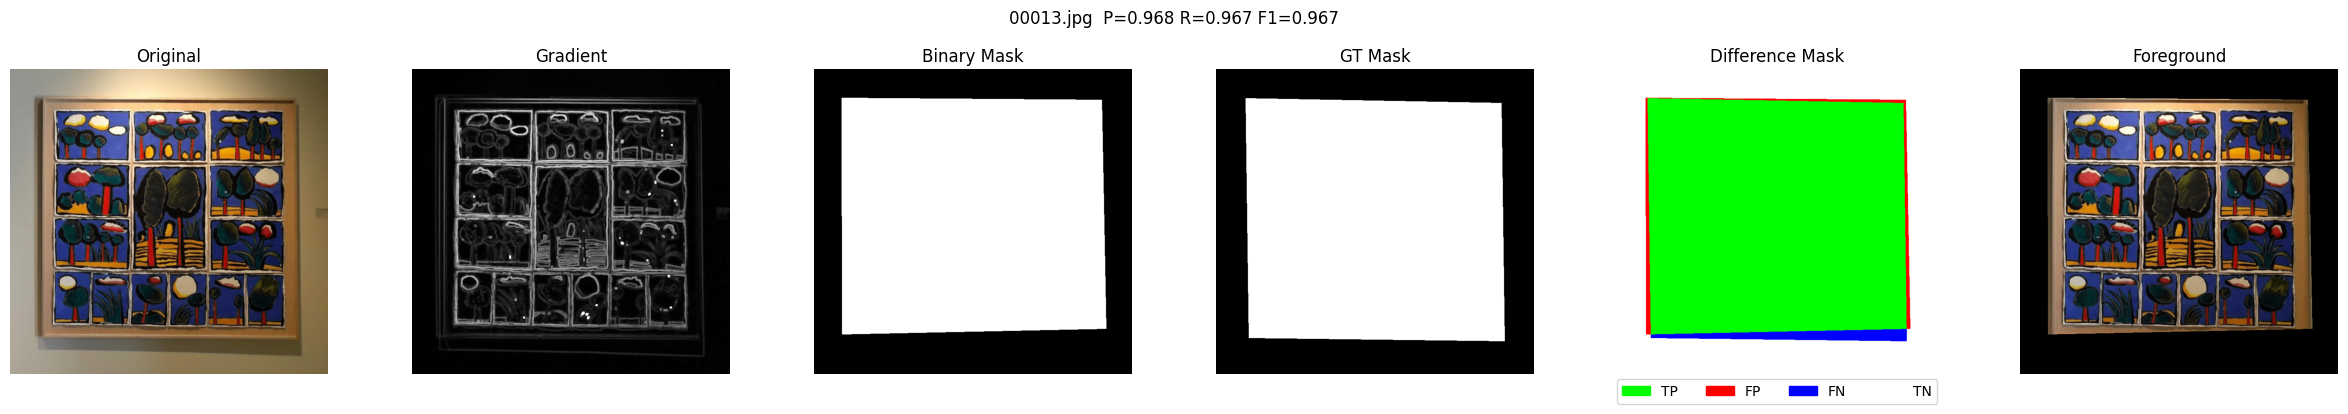

00014.jpg -> Precision: 0.8121, Recall: 0.9997, F1: 0.8962


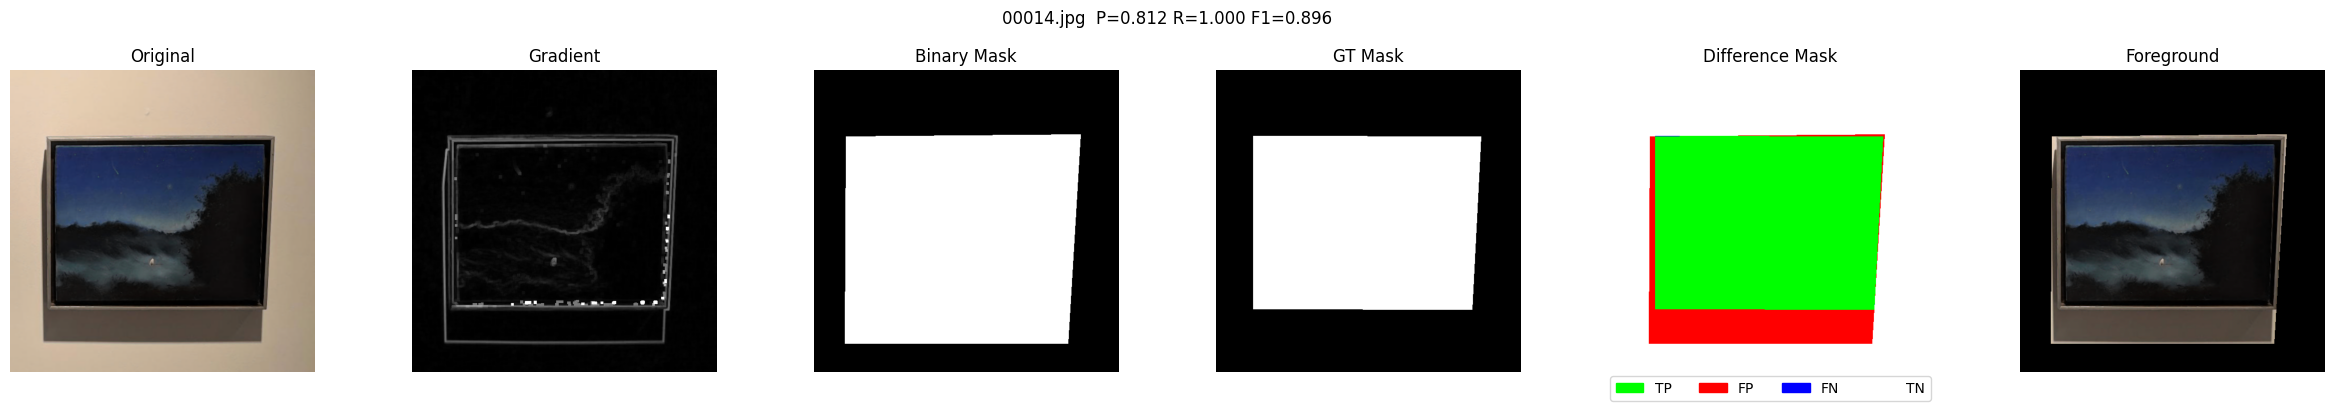

00015.jpg -> Precision: 1.0000, Recall: 0.9672, F1: 0.9833


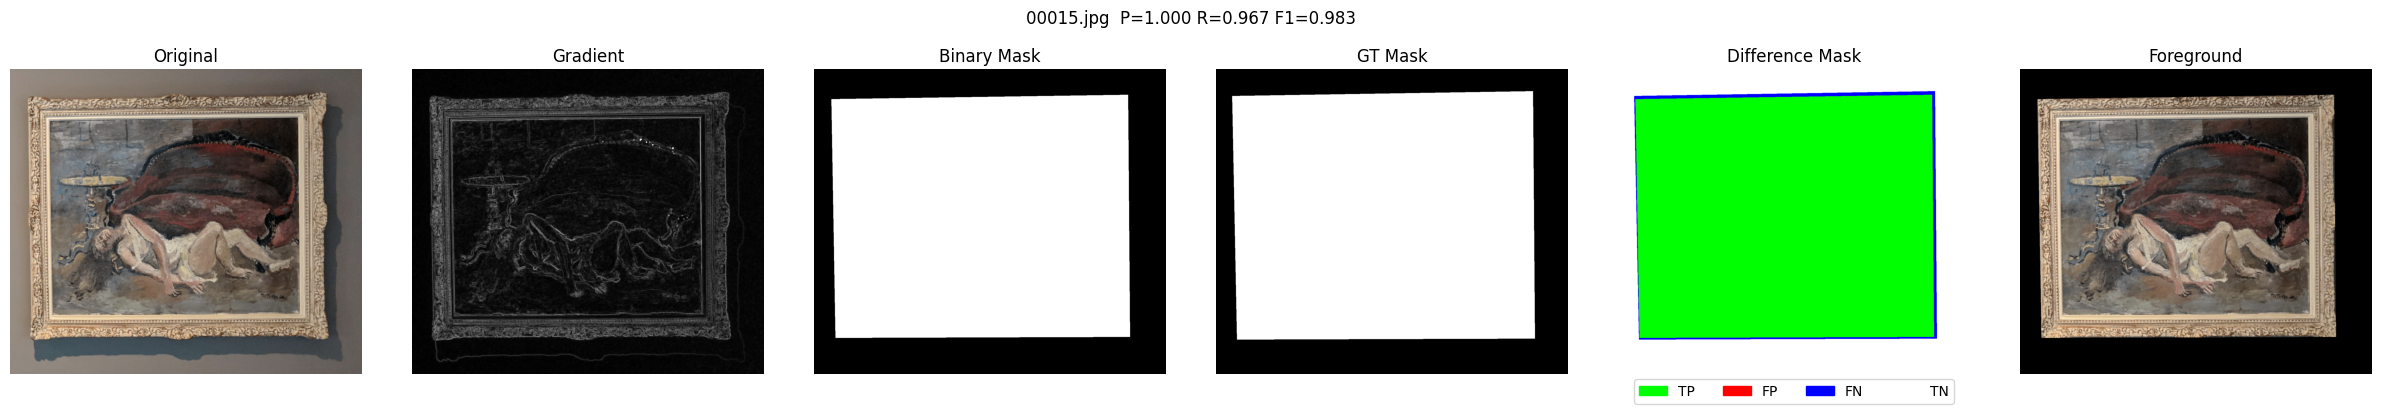

00016.jpg -> Precision: 0.9992, Recall: 0.9966, F1: 0.9979


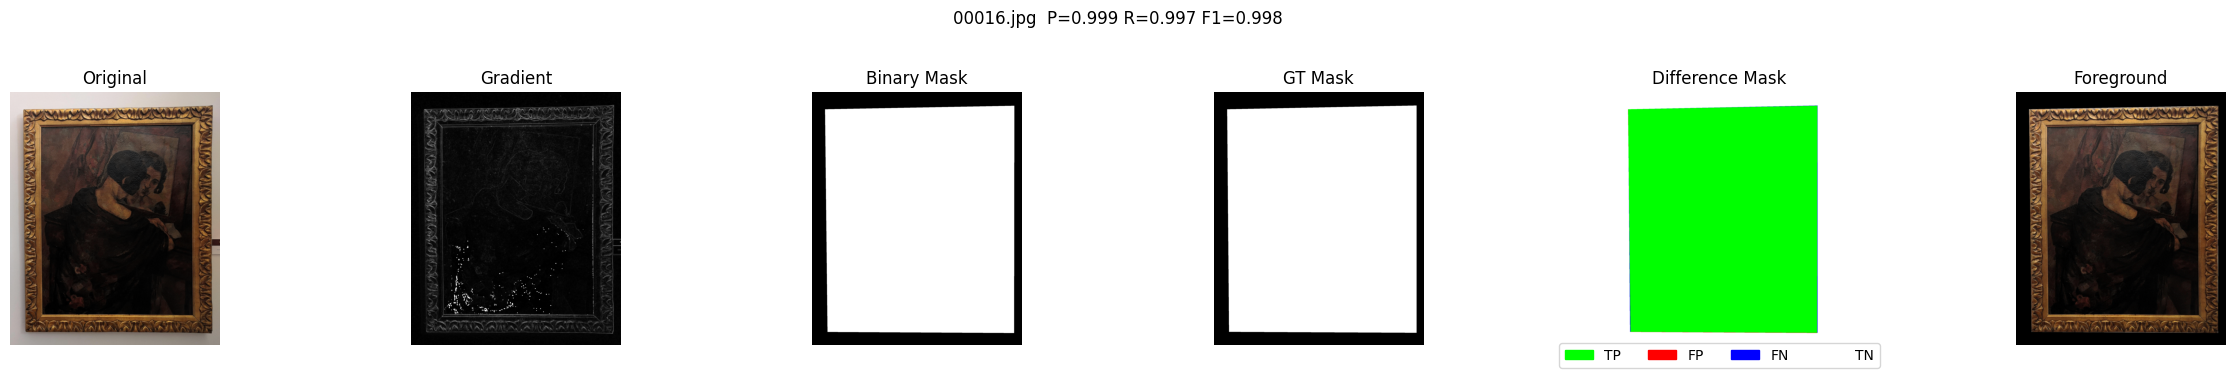

00017.jpg -> Precision: 0.9995, Recall: 0.9892, F1: 0.9943


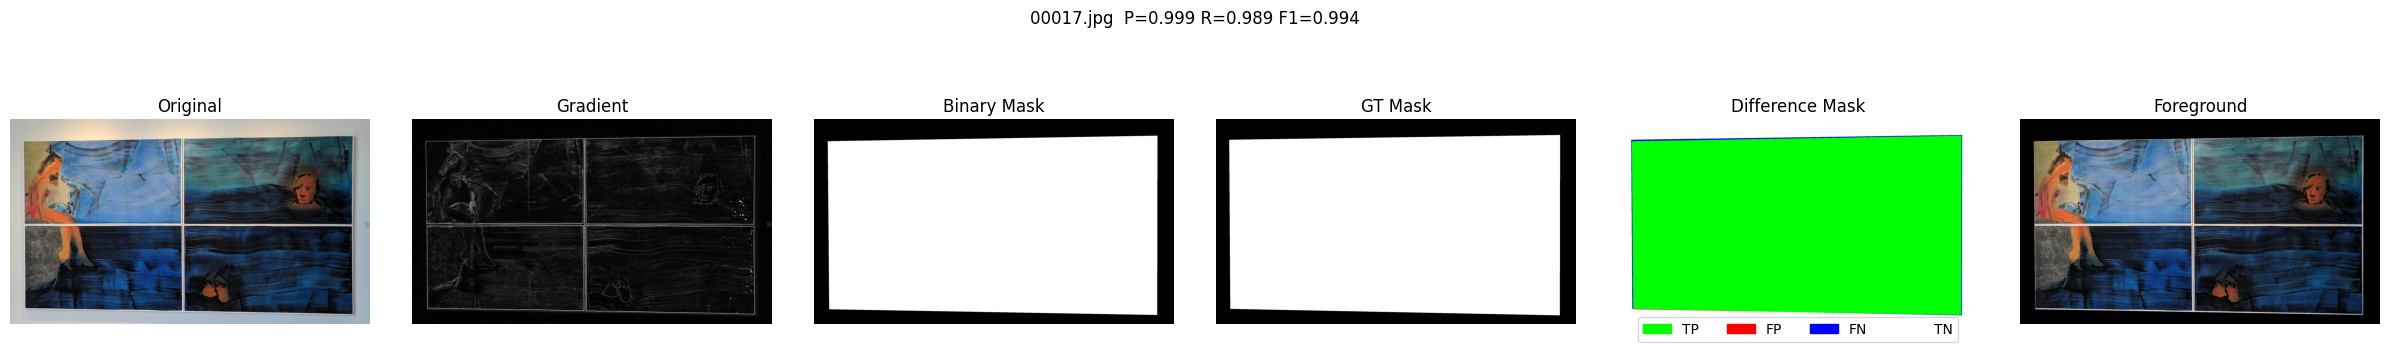

00018.jpg -> Precision: 0.9186, Recall: 1.0000, F1: 0.9575


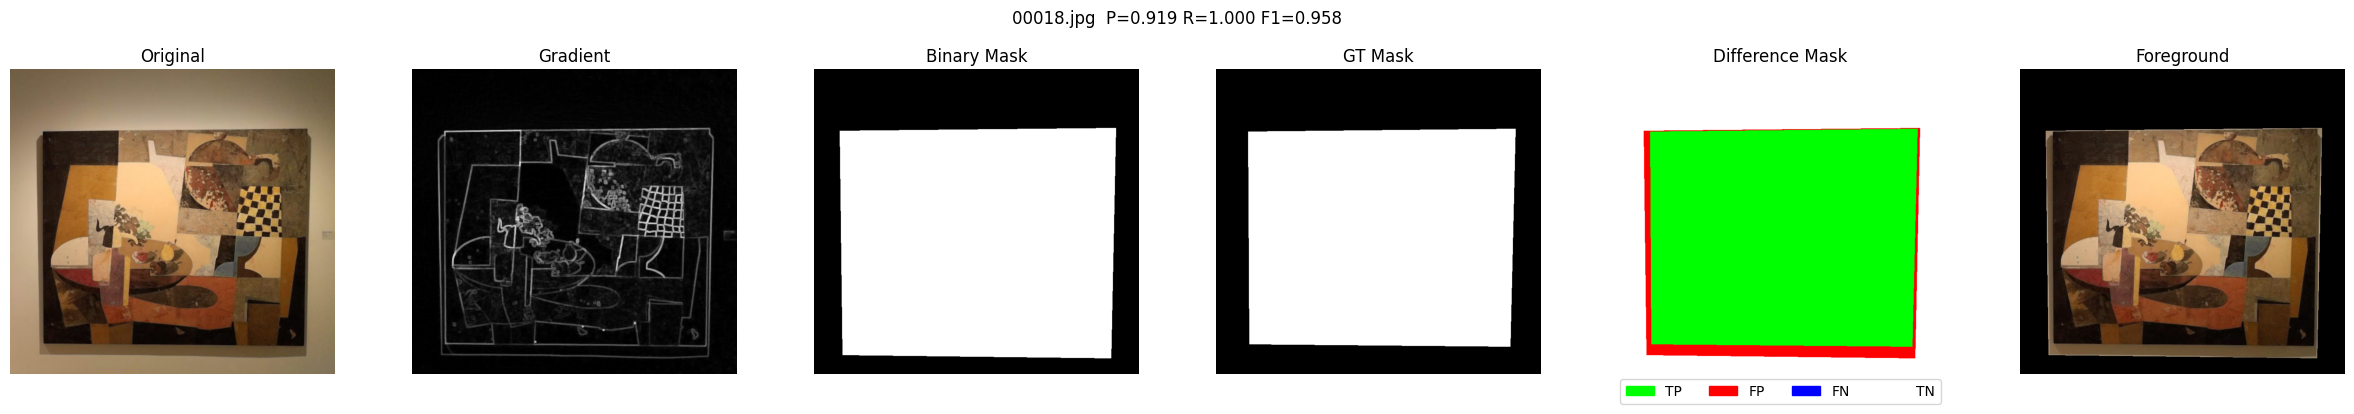

00019.jpg -> Precision: 0.9501, Recall: 1.0000, F1: 0.9744


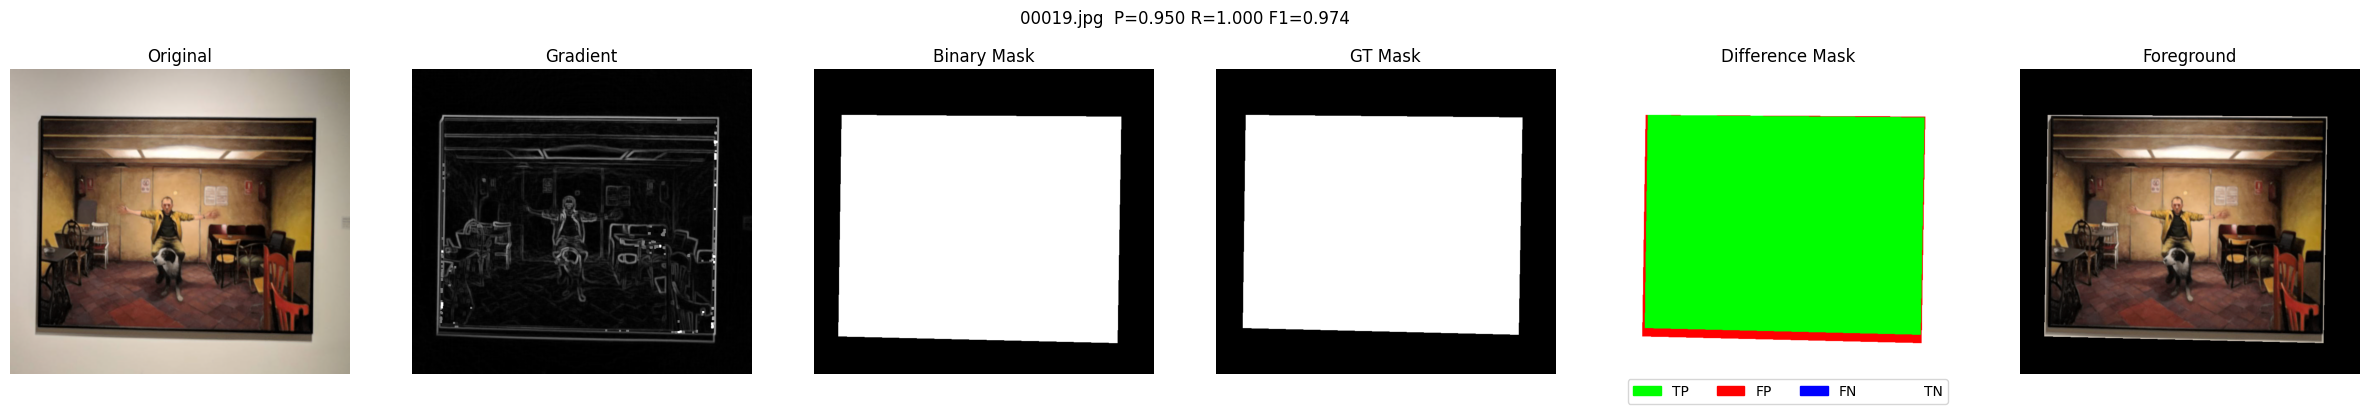

00020.jpg -> Precision: 0.9630, Recall: 0.9990, F1: 0.9806


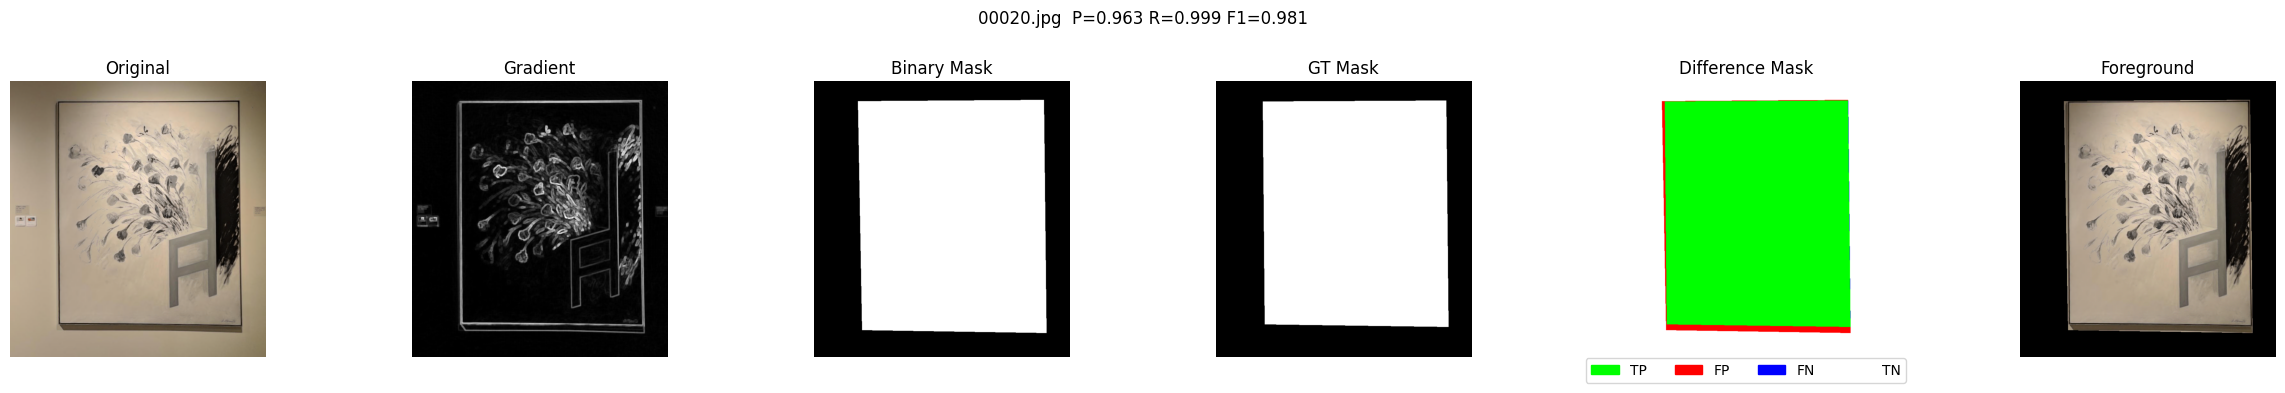

00021.jpg -> Precision: 0.9210, Recall: 1.0000, F1: 0.9589


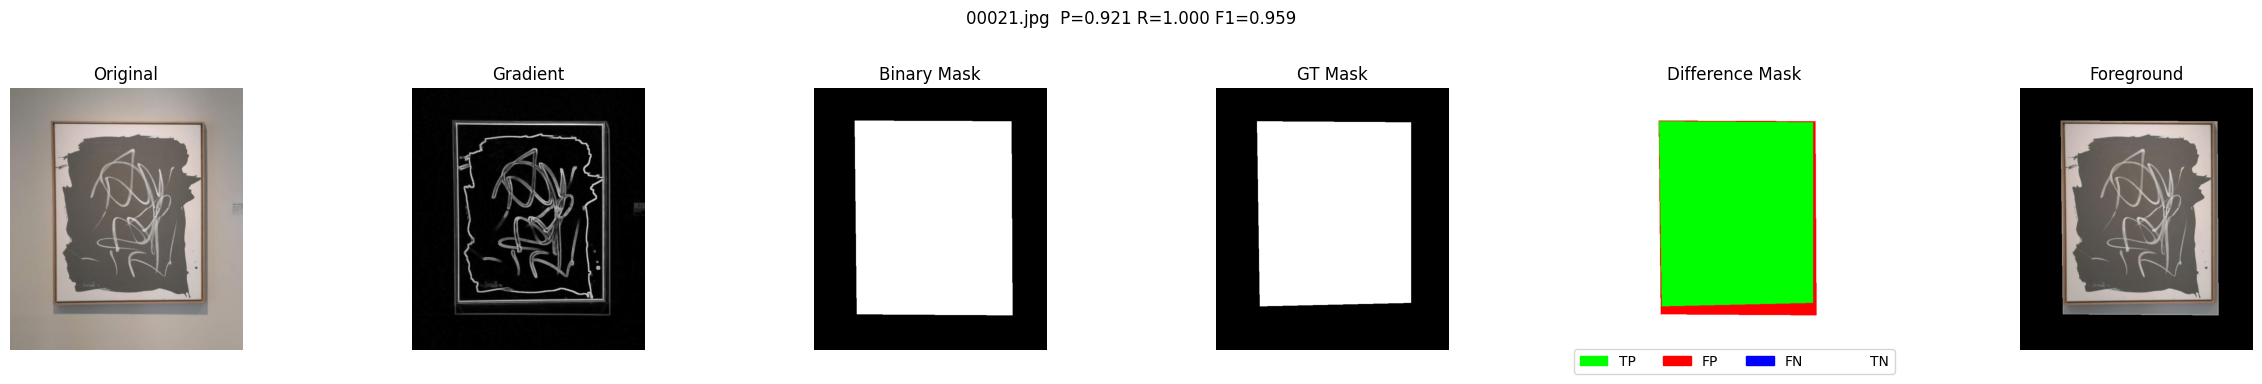

00022.jpg -> Precision: 0.8862, Recall: 1.0000, F1: 0.9397


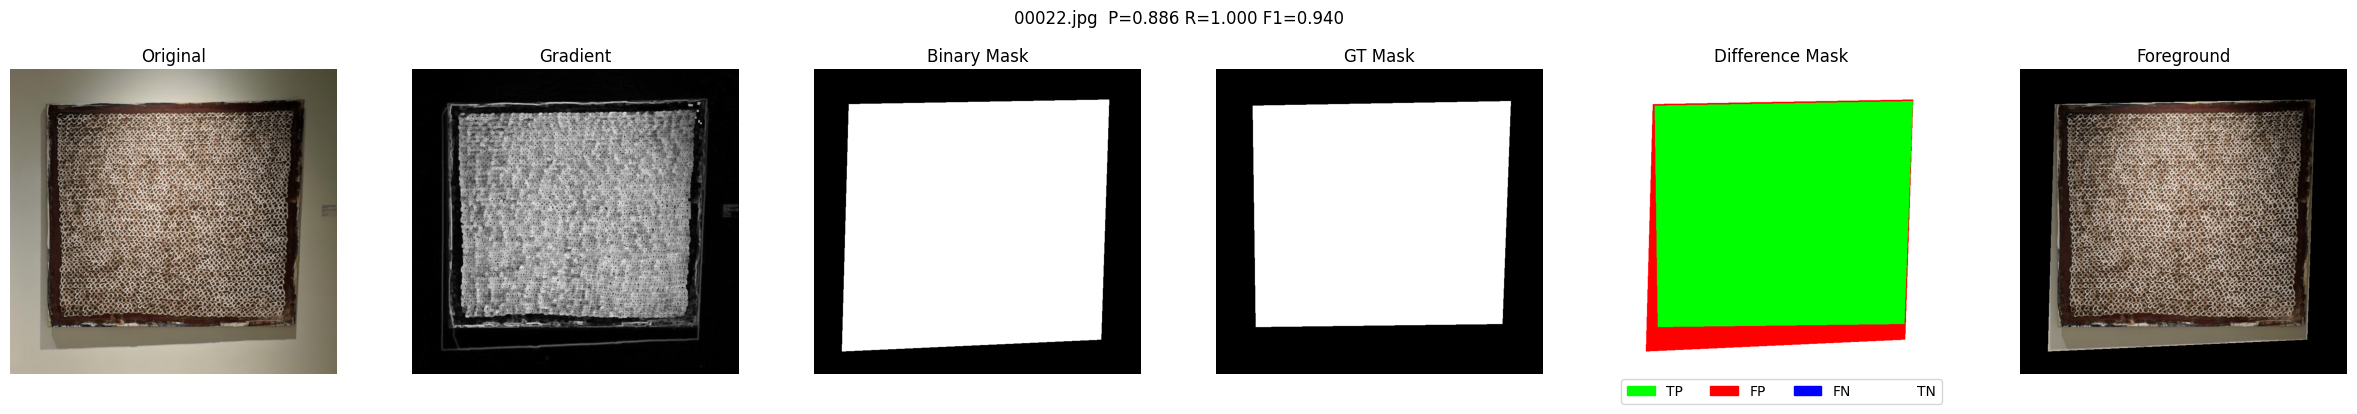

00023.jpg -> Precision: 0.9946, Recall: 0.9948, F1: 0.9947


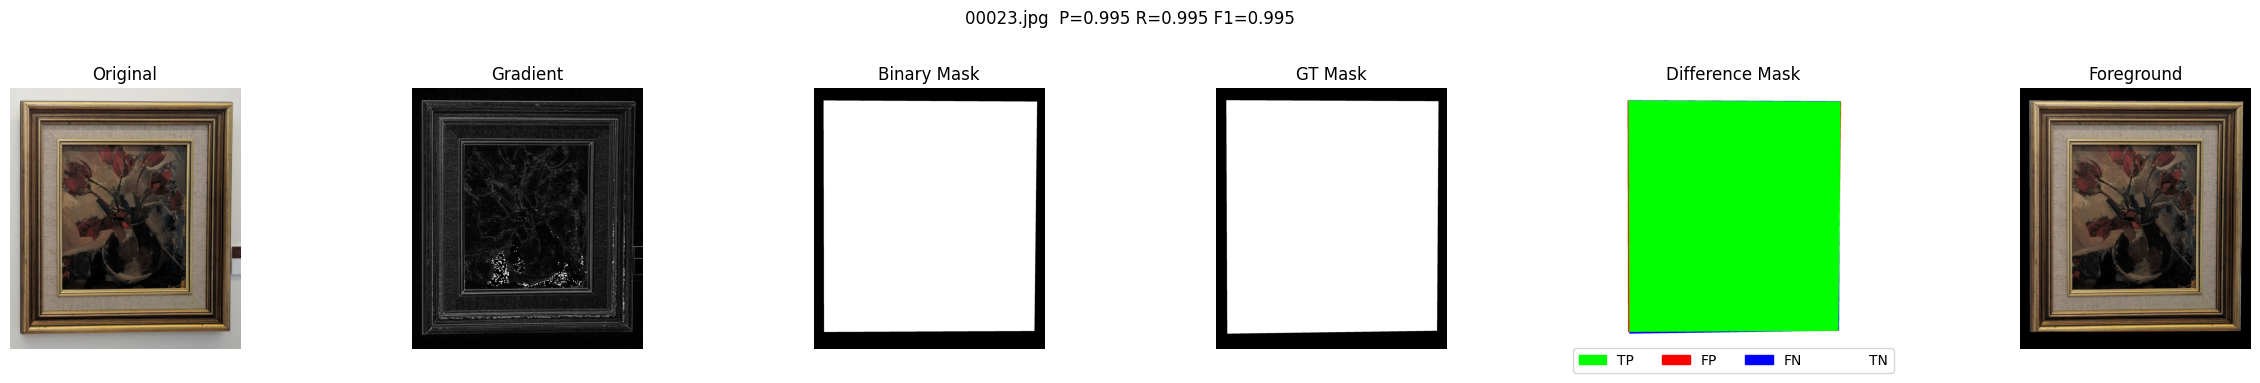

00024.jpg -> Precision: 0.9302, Recall: 1.0000, F1: 0.9639


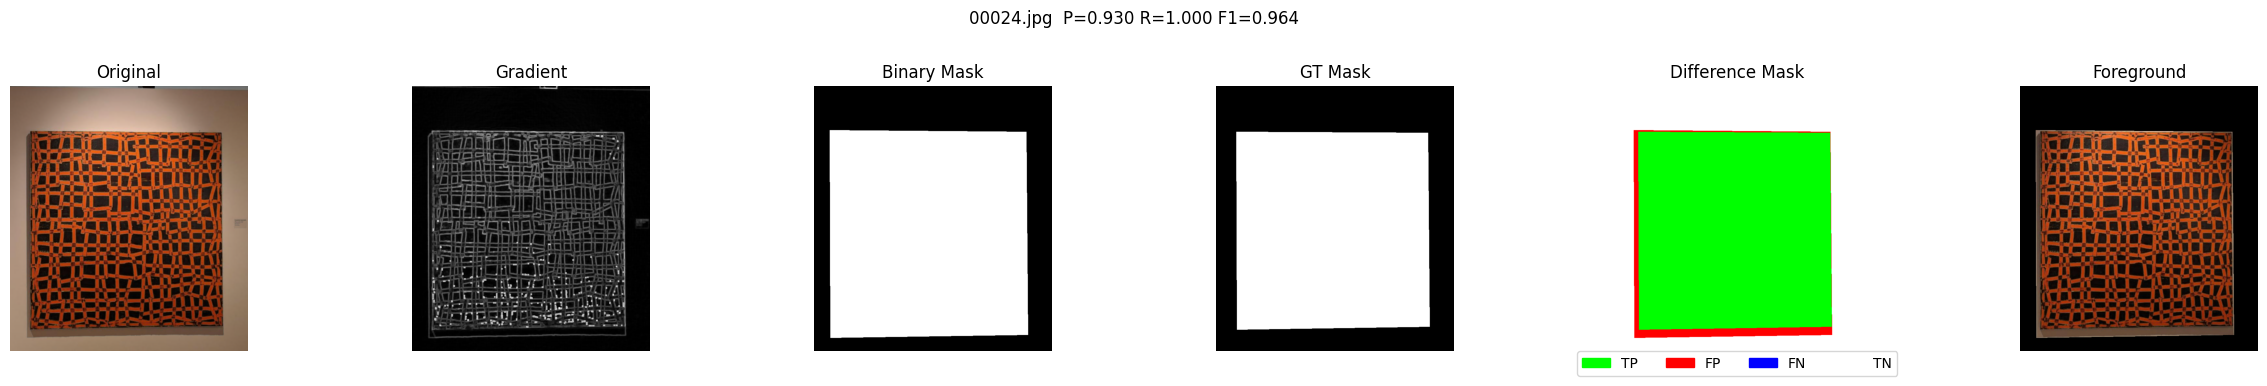

00025.jpg -> Precision: 0.9786, Recall: 0.9682, F1: 0.9734


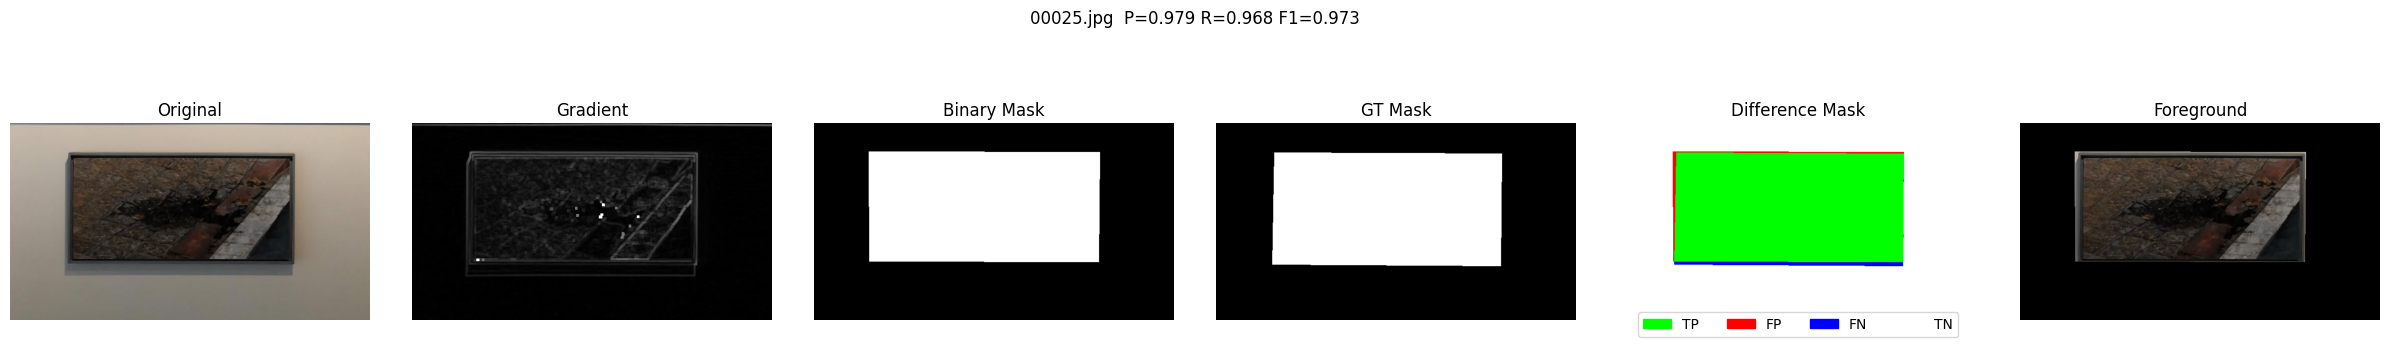

00026.jpg -> Precision: 0.9006, Recall: 1.0000, F1: 0.9477


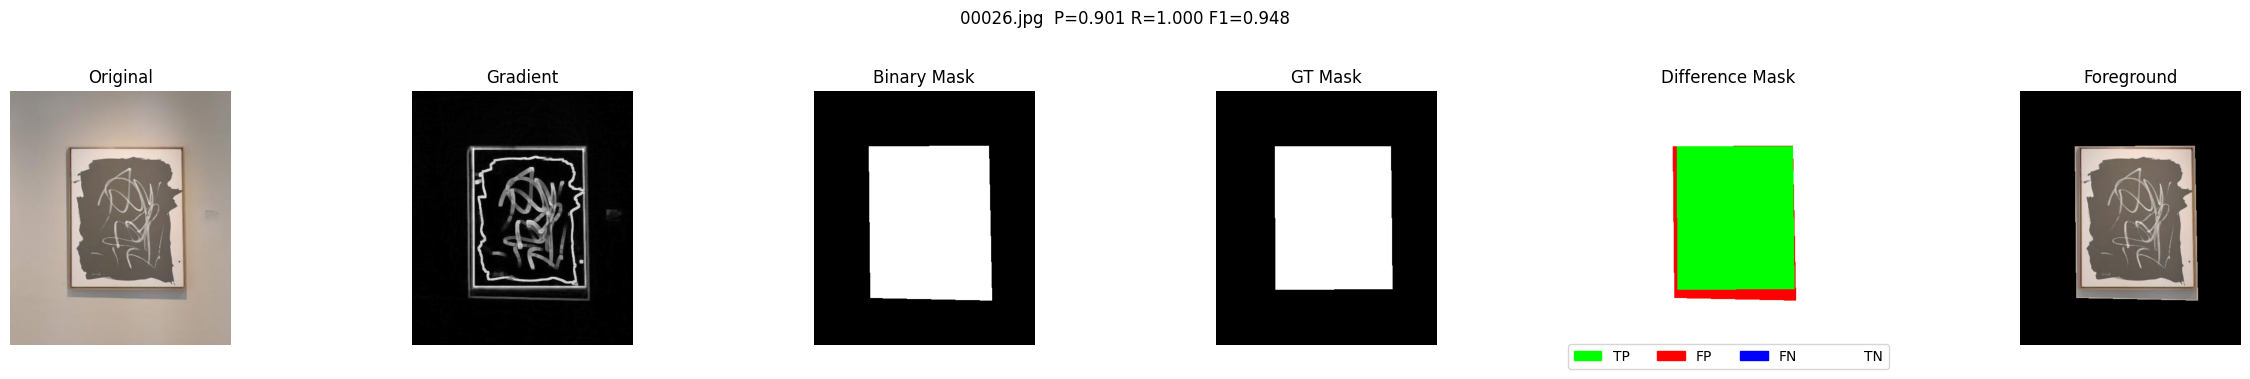

00027.jpg -> Precision: 0.9033, Recall: 1.0000, F1: 0.9492


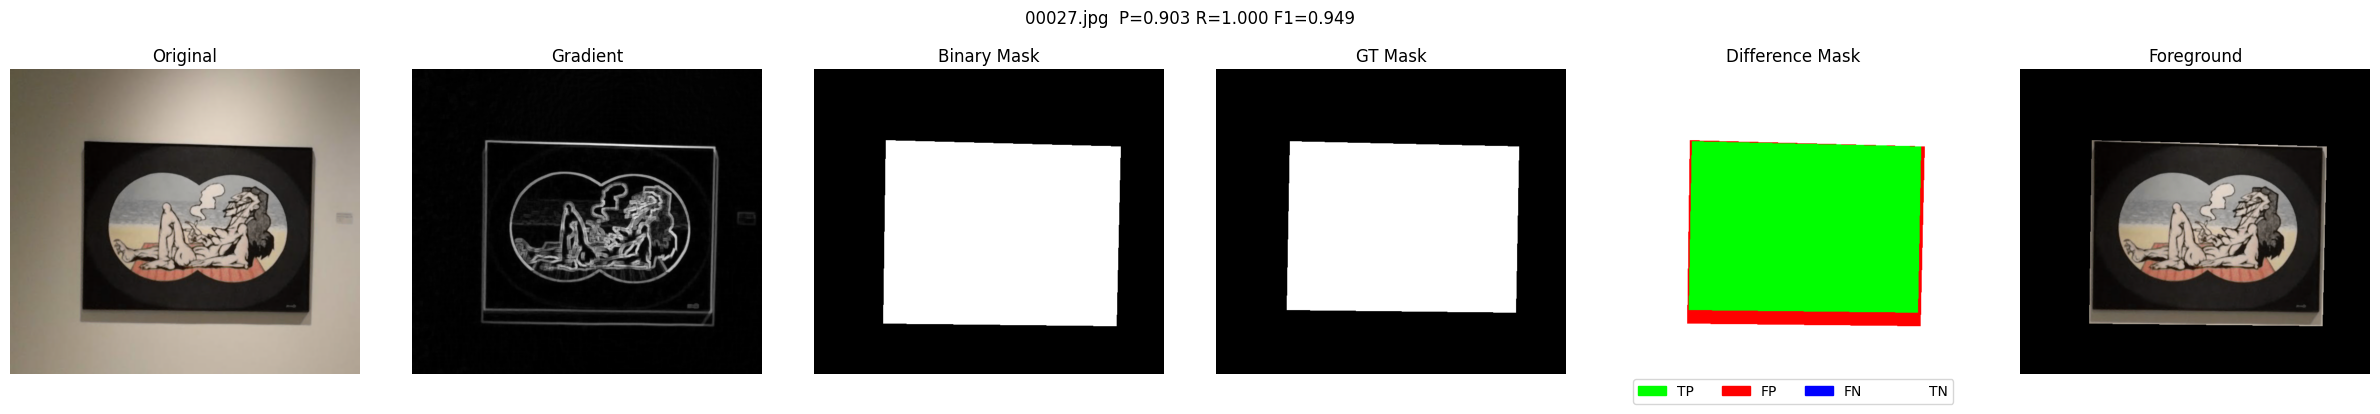

00028.jpg -> Precision: 0.9270, Recall: 0.9935, F1: 0.9591


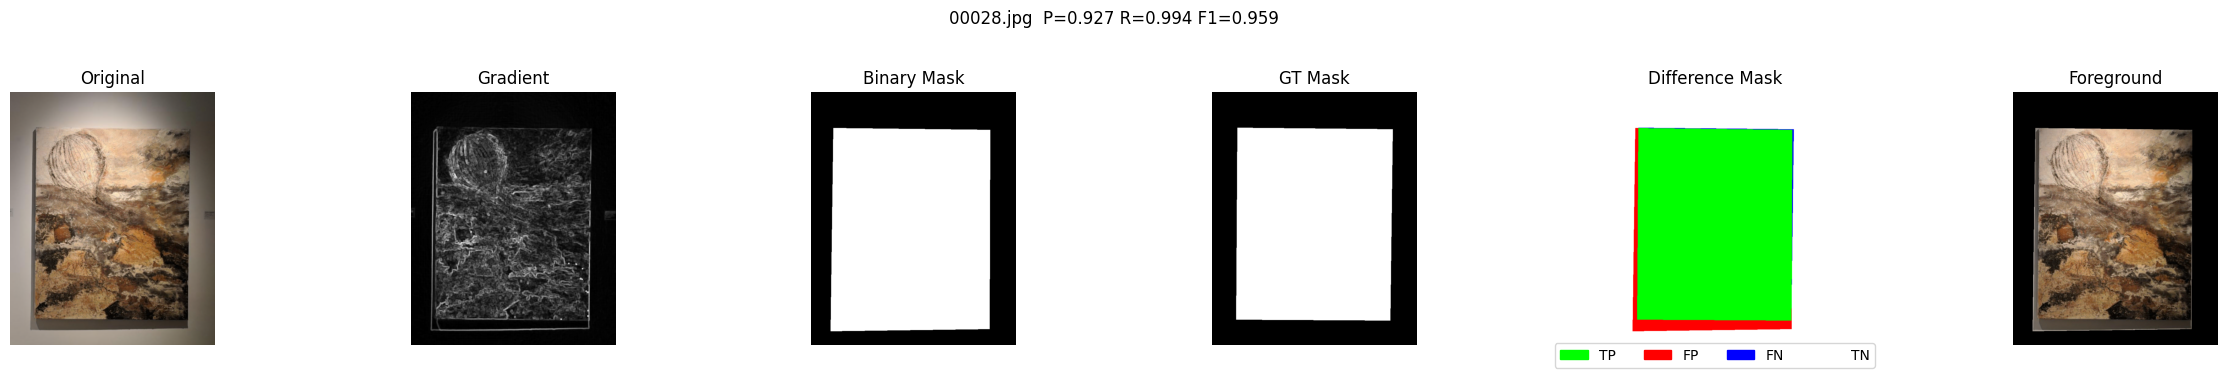

00029.jpg -> Precision: 0.9088, Recall: 1.0000, F1: 0.9522


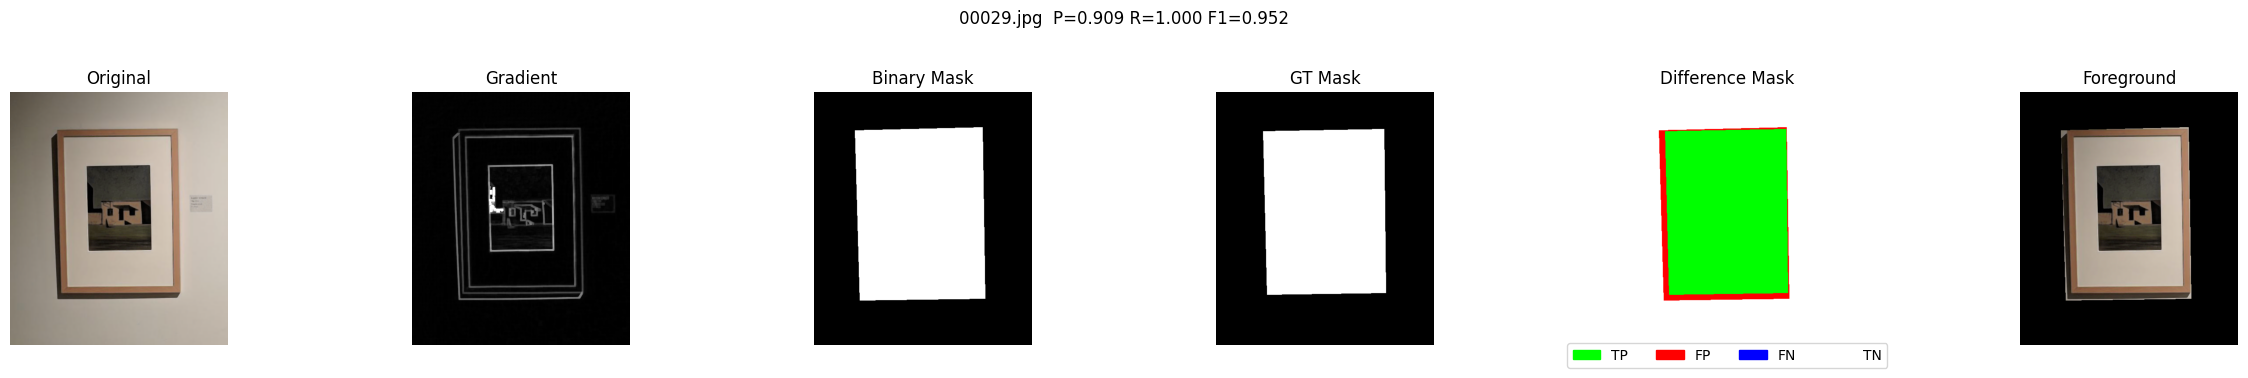


=== Global pixel-wise metrics ===
Total TP: 27657341, FP: 577574, FN: 154857, TN: 11131854
Global Precision: 0.9795
Global Recall:    0.9944
Global F1:        0.9869


In [94]:
# Iterar sobre imágenes, comparar con GT, calcular métricas y mostrar resultados
import matplotlib.patches as mpatches

# Toggle plotting of images. Set to False to speed-up and only print metrics.
SHOW_PLOTS = True

total_TP = total_FP = total_FN = total_TN = 0
precisions = []
recalls = []
f1s = []

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    im = imageio.imread(image_path)
    # Now the function returns the gradient as grad_norm (2D uint8) instead of using a global debug list
    original_image, pred_mask, foreground, grad_norm = remove_background_morphological_gradient(im, filter='median', save_debug=False, thr=20, pixel_border=15)

    
    # Asegurar máscara booleana predicha
    pred_bool = pred_mask.astype(bool)

    # Cargar GT (mismo nombre .png) y convertir a máscara booleana
    base = os.path.splitext(image_file)[0]
    gt_path = os.path.join(image_folder, base + '.png')
    if os.path.exists(gt_path):
        gt_raw = imageio.imread(gt_path)
        # Si GT tiene canales, convertir a gris
        if gt_raw.ndim == 3:
            gt_gray = rgb2gray(gt_raw)
        else:
            gt_gray = gt_raw
        gt_bool = gt_gray > 127
    else:
        gt_bool = np.zeros(pred_bool.shape, dtype=bool)

    # Calcular TP, FP, FN, TN (por píxel)
    TP = np.logical_and(pred_bool, gt_bool).sum()
    FP = np.logical_and(pred_bool, np.logical_not(gt_bool)).sum()
    FN = np.logical_and(np.logical_not(pred_bool), gt_bool).sum()
    TN = np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)).sum()

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

    # Precision, Recall, F1 para la imagen
    P = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    R = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0.0

    precisions.append(P)
    recalls.append(R)
    f1s.append(F1)

    print(f"{image_file} -> Precision: {P:.4f}, Recall: {R:.4f}, F1: {F1:.4f}")

    # If plotting is disabled, skip constructing and showing figures
    if not SHOW_PLOTS:
        continue

    # Create image of difference coloured (TP=green, FP=red, FN=blue, TN=white)
    h, w = pred_bool.shape
    diff_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    diff_rgb[np.logical_and(pred_bool, gt_bool)] = [0, 255, 0]     # TP verde
    diff_rgb[np.logical_and(pred_bool, np.logical_not(gt_bool))] = [255, 0, 0]  # FP rojo
    diff_rgb[np.logical_and(np.logical_not(pred_bool), gt_bool)] = [0, 0, 255]  # FN azul
    diff_rgb[np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool))] = [255, 255, 255]  # TN blanco

    # Prepare gradient RGB for display (stack single-channel to 3)
    grad_rgb = np.stack([grad_norm, grad_norm, grad_norm], axis=-1)

    # Mostrar: Original | Gradient | Binary Mask | GT Mask | Difference Mask | Foreground
    plt.figure(figsize=(24, 4))

    plt.subplot(1, 6, 1)
    plt.title('Original')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.title('Gradient')
    plt.imshow(grad_rgb)
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.title('Binary Mask')
    plt.imshow(pred_bool, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.title('GT Mask')
    plt.imshow(gt_bool, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.title('Difference Mask')
    plt.imshow(diff_rgb)
    plt.axis('off')

    # Leyenda para Difference Mask
    patches = [
        mpatches.Patch(color=(0, 1, 0), label='TP'),
        mpatches.Patch(color=(1, 0, 0), label='FP'),
        mpatches.Patch(color=(0, 0, 1), label='FN'),
        mpatches.Patch(color=(1, 1, 1), label='TN')
    ]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=4)

    plt.subplot(1, 6, 6)
    plt.title('Foreground')
    plt.imshow(foreground)
    plt.axis('off')

    plt.suptitle(f"{image_file}  P={P:.3f} R={R:.3f} F1={F1:.3f}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Métricas globales por píxel (acumuladas)
global_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
global_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
global_f1 = 2 * global_precision * global_recall / (global_precision + global_recall) if (global_precision + global_recall) > 0 else 0.0

print('\n=== Global pixel-wise metrics ===')
print(f'Total TP: {total_TP}, FP: {total_FP}, FN: {total_FN}, TN: {total_TN}')
print(f'Global Precision: {global_precision:.4f}')
print(f'Global Recall:    {global_recall:.4f}')
print(f'Global F1:        {global_f1:.4f}')